<p align="center" width="100%">
    <img width="66%" src="https://raw.githubusercontent.com/linukc/master_dlcourse/main/images/logo.png">
</p>

 # **[MIPT DL frameworks Spring 2024](https://wiki.cogmodel.mipt.ru/s/mtai/doc/2024-nejrosetevye-frejmvorki-glubokogo-obucheniya-ZBGd69bxLd). Class 5: Image Classification**

## Предобработка данных

In [ ]:
# transform = DataAugmentationDINO(
#     global_crops_scale=(0.4, 1.),
#     local_crops_scale=(0.05, 0.4),
#     local_crops_number=8,
# )
# dataset = datasets.ImageFolder(args.data_path, transform=transform)

**global_crops_scale** - Scale range of the cropped image before resizing, relatively to the origin image.Used for large global view cropping

**local_crops_scale** - Scale range of the cropped image before resizing, relatively to the origin image

**local_crops_number** - Number of small local views to generate

In [ ]:
import torch
from torchvision import datasets, transforms
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.io import read_image

In [ ]:
class DataAugmentationDINO(object):
    def __init__(self, global_crops_scale, local_crops_scale, local_crops_number):
        flip_and_color_jitter = transforms.Compose([
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.RandomApply(
                [transforms.ColorJitter(brightness=0.4, contrast=0.4, saturation=0.2, hue=0.1)],
                p=0.8
            ),
            transforms.RandomGrayscale(p=0.2),
        ])
        normalize = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
        ])

        # first global crop
        self.global_transfo1 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            transforms.GaussianBlur(3, 1.0),
            normalize,
        ])
        # second global crop
        self.global_transfo2 = transforms.Compose([
            transforms.RandomResizedCrop(224, scale=global_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            transforms.GaussianBlur(3, 0.1),
            transforms.RandomSolarize(128, 0.2),
            normalize,
        ])
        # transformation for the local small crops
        self.local_crops_number = local_crops_number
        self.local_transfo = transforms.Compose([
            transforms.RandomResizedCrop(96, scale=local_crops_scale, interpolation=Image.BICUBIC),
            flip_and_color_jitter,
            transforms.GaussianBlur(3, 0.5),
            normalize,
        ])

    def __call__(self, image):
        crops = []
        crops.append(self.global_transfo1(image))
        crops.append(self.global_transfo2(image))
        for _ in range(self.local_crops_number):
            crops.append(self.local_transfo(image))
        return crops

In [ ]:
!mkdir -p example_dataset/example
!wget -q -O example_dataset/example/example.jpg https://unsplash.it/1920/1080/?random

In [ ]:
transform = DataAugmentationDINO(
    global_crops_scale=(0.4, 1.),
    local_crops_scale=(0.05, 0.4),
    local_crops_number=8,
)
dataset = datasets.ImageFolder(r"/content/example_dataset", transform=transform)

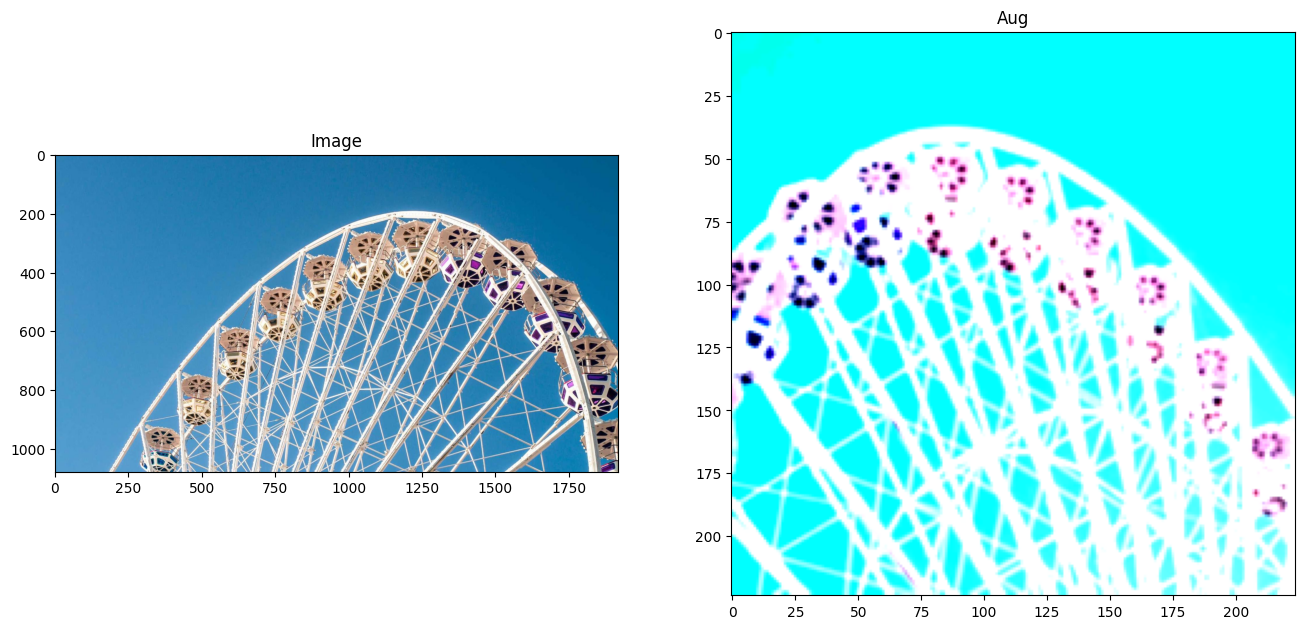

In [ ]:
torch.manual_seed(0)

image = read_image("/content/example_dataset/example/example.jpg")
aug = dataset[0][0][0]

plt.figure(figsize=(16, 8))
plt.subplot(121)
plt.title("Image")
plt.imshow(image.permute(1, 2, 0))
plt.subplot(122)
plt.title("Aug")
plt.imshow(aug.permute(1, 2, 0))

## Особенности архитектуры модели

Интерполяция позиционного кодирования под разные разрешения изображений.

In [ ]:
import math
import torch
from torch import nn

In [ ]:
def interpolate_pos_encoding(pos_embed, patch_embed_patch_size, w, h):
    # npatch = x.shape[1] - 1
    # N = pos_embed.shape[1] - 1
    # if npatch == N and w == h:
    #     return pos_embed
    class_pos_embed = pos_embed[:, 0]
    patch_pos_embed = pos_embed[:, 1:]
    dim = pos_embed.shape[-1]
    w0 = w // patch_embed_patch_size
    h0 = h // patch_embed_patch_size
    N = pos_embed.shape[1] - 1
    # we add a small number to avoid floating point error in the interpolation
    # see discussion at https://github.com/facebookresearch/dino/issues/8
    w0, h0 = w0 + 0.1, h0 + 0.1
    patch_pos_embed = nn.functional.interpolate(
        patch_pos_embed.reshape(1, int(math.sqrt(N)), int(math.sqrt(N)), dim).permute(0, 3, 1, 2),
        scale_factor=(w0 / math.sqrt(N), h0 / math.sqrt(N)),
        mode='bicubic',
    )
    assert int(w0) == patch_pos_embed.shape[-2] and int(h0) == patch_pos_embed.shape[-1]
    patch_pos_embed = patch_pos_embed.permute(0, 2, 3, 1).view(1, -1, dim)
    return torch.cat((class_pos_embed.unsqueeze(0), patch_pos_embed), dim=1)

In [ ]:
num_patches = 9
embed_dim = 5
pos_embed = torch.rand(1, num_patches + 1, embed_dim)

interpolate_pos_encoding(pos_embed, patch_embed_patch_size=1, w=2, h=2)

tensor([[[0.3533, 0.3038, 0.9383, 0.0499, 0.2048],
         [0.1648, 0.5877, 0.2820, 0.7178, 0.3133],
         [0.3196, 0.1952, 0.4192, 0.4753, 0.6649],
         [0.4733, 0.7280, 0.8049, 0.5049, 0.5036],
         [0.6103, 0.7323, 0.5334, 0.2944, 0.6417]]])

https://github.com/facebookresearch/dino/blob/main/utils.py#L594

## Loss функция

In [ ]:
from torch import nn
import numpy as np
import torch.nn.functional as F

In [ ]:
class DINOLoss(nn.Module):
    def __init__(self, out_dim, ncrops, warmup_teacher_temp, teacher_temp,
                 warmup_teacher_temp_epochs, nepochs, student_temp=0.1,
                 center_momentum=0.9):
        super().__init__()
        self.student_temp = student_temp
        self.center_momentum = center_momentum
        self.ncrops = ncrops
        self.register_buffer("center", torch.zeros(1, out_dim))
        # we apply a warm up for the teacher temperature because
        # a too high temperature makes the training instable at the beginning
        self.teacher_temp_schedule = np.concatenate((
            np.linspace(warmup_teacher_temp,
                        teacher_temp, warmup_teacher_temp_epochs),
            np.ones(nepochs - warmup_teacher_temp_epochs) * teacher_temp
        ))

    def forward(self, student_output, teacher_output, epoch):
        """
        Cross-entropy between softmax outputs of the teacher and student networks.
        student_output [b, n, k]
        teacher_output [b, n, k]

        """
        student_out = student_output / self.student_temp
        student_out = student_out.chunk(self.ncrops)

        # teacher centering and sharpening
        temp = self.teacher_temp_schedule[epoch]
        teacher_out = F.softmax((teacher_output - self.center) / temp, dim=-1)
        teacher_out = teacher_out.detach().chunk(2)

        total_loss = 0
        n_loss_terms = 0
        for iq, q in enumerate(teacher_out):
            for v in range(len(student_out)):
                if v == iq:
                    # we skip cases where student and teacher operate on the same view
                    continue
                loss = torch.sum(-q * F.log_softmax(student_out[v], dim=-1), dim=-1)
                total_loss += loss.mean()
                n_loss_terms += 1
        total_loss /= n_loss_terms
        self.update_center(teacher_output)
        return total_loss

    @torch.no_grad()
    def update_center(self, teacher_output):
        """
        Update center used for teacher output.
        """
        batch_center = torch.sum(teacher_output, dim=0, keepdim=True)
        batch_center = batch_center / len(teacher_output)

        # ema update
        self.center = self.center * self.center_momentum + batch_center * (1 - self.center_momentum)

## Домашнее задание

Выбрать и зафиксировать модель трансформера. Выбрать два набора данных: обобщающий для предобучения, специфичный для finetuning.

1) Предобучить DINO на большом наборе

2) finetune модель учителя на малом наборе

3) сравнить с обученной моделью только на малом наборе.